In [10]:
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

# A Comprehensive Analysis of Peridynamics

Alejandro Francisco Queiruga

**TL;DR:** I advise against the use of Peridynamics.

## Introduction

This notebook replicates some of the results of 

> Queiruga, A. F. and G. J. Moridis, "Numerical experiments on 
>  the convergence properties of state-based peridynamic laws and 
>  influence functions in two-dimensional problems." Computer 
>  Methods in Applied Mechanics and Engineering 322 (2017): 
>  97-122.

PeriFlakes, of which is this notebook is a part, is an open source implementation of Peridynamics that can quickly generate and analyze state-based schemes. The database in this repository contains a huge set of runs with many permutations on the theoretical formulations that were used to solve constant-strain problems and the thin crack problem. The original analysis was performed similarly using org-mode to embed the analysis into the the paper source. Org-mode is a bit of a beast, so I have replicated this simplified version using Jupyter. 



I like to use my [SimDataDB](https://github.com/afqueiruga/SimDataDB) wrapper for cursor and entry-adding management, but the database is just a regular `sqlite3` table. There are four tables, each with with the same five columns:

In [11]:
from SimDataDB import *
sdb = SimDataDB('PeriFlakes/results.db')
print sdb.Query("SELECT name FROM sqlite_master WHERE type='table';")
print [ (_[1],_[2]) for _ in sdb.Query("PRAGMA table_info(uniaxial)")]

[[u'isotropic'], [u'shear'], [u'uniaxial']]
[(u'method', u'TEXT'), (u'weight', u'TEXT'), (u'RF', u'FLOAT'), (u'N', u'INT'), (u'u', u'array')]


The first two columns label the scheme by constitutive law and weight (influence) function $w$, $RF$ is the support radius (which is also an artificial hyperparameter!), $N$ is the number of nodes along one side of the $(-1,1)\times(-1,1)$ domain, and $u$ is a binary blob of the entire numpy array storing the solution.

This a list of all of the different methods we consider:

In [12]:
print sdb.Query("SELECT DISTINCT method FROM uniaxial")

[[u'Fbased'], [u'Fstab_Littlewood'], [u'Fstab_Silling'], [u'Oterkus2'], [u'Silling']]


Oterkus2 and Silling are two different dilation based method, which we will show to not be acceptable. The method Fbased is Siling's deformation gradient based method with a correspondence to continuum mechanics

# Constant Strain Problems

The patch test in finite element analysis asserts that any new finite element must be able to exactly represent any random constant strain case with any randomly perturbed element mesh, and give exactly the correct stress. Peridynamic codes don't have that property. To investigate further, we break down the constant strain cases into three main modes:

![three modes](images/blocks.png)

(The bottom of the uniaxial and shear domains are also rollers.) These are the sorts of problems that a freshman engineering student will learn. The analytical
solution for these problems are: 

| Test      | Solution                                         |
|-----------|:------------------------------------------------:|
| Uniaxial  | $u_{y,anal}=T H \frac{ 2 \nu^2 + \nu -1 }{E(\nu-1)}$ |
| Isotropic | $u_{y,anal}=T H \frac{ 1 - \nu - 2 \nu^2 }{E}$ |
| Shear     | $u_{x,anal}=2 T H \frac{ 1+\nu}{E}$            |

The properties that we used in the problem are

In [13]:
H = 2.0 ; T = 1.0 ; E = 1.0 ; nu = 0.25;

### Properties of the solutions

Let's access one of Peridynamics solutions from the database. The solutions are stored as flattened out arrays, so we do a reshape. The domains are always square, and the displacements are 2D vectors. To save space, the point positions are not stored, but they can be reconstructed easily. Let us access one method that does not look too bad, Silling's dilation based model using a cubic influence function.

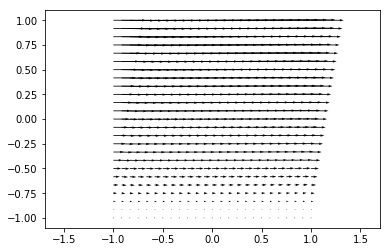

In [14]:
N,u = sdb.Query("SELECT N,u FROM shear WHERE method='Silling' and weight='cubic' and N=25 and RF=1.5")[0]
u = u.reshape(N,N,2)
xx,yy = np.meshgrid(np.linspace(-1,1,N),np.linspace(-1,1,N))
ax = plt.gca()
ax.quiver(xx,yy,u[:,:,0],u[:,:,1],angles='xy',scale_units='xy',scale=1)
ax.set_aspect('equal', 'datalim')
plt.draw()

This is a shear problem and that does *look* like proper shear deformation. Let's take a look closer at the profile:

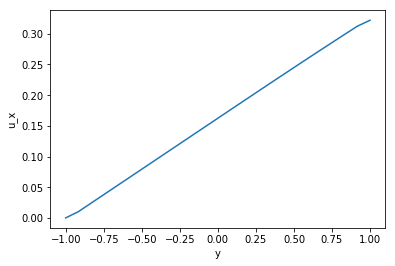

In [15]:
plt.plot(yy[:,N/2],u[:,N/2,0])
plt.xlabel('y'); plt.ylabel('u_x');

Notice how we can see the little dips at the end points where we get the well known edge effects. We can see them even more pronouced if we look at the x solution:

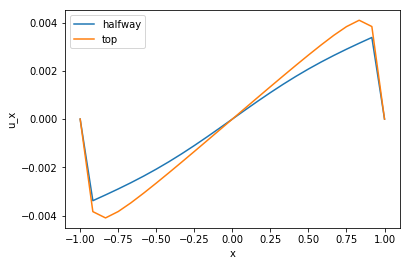

In [16]:
plt.plot(yy[:,N/2],u[N/2,:,1],label='halfway');
plt.plot(yy[:,N/2],u[-1,:,1],label='top');
plt.legend()
plt.xlabel('x'); plt.ylabel('u_x');

Upon closer inspection, we see that doesn't look good at all! This is a significant erroneous displacement!

## Thin Crack

Those above problems are very crucial. Those disqualify the dilation based models as acceptable simulations, and show that the deformation gradient method isn't great as well. 

But let's go ahead and see how it behaves around a crack, because that's the whole point of the method. We consider an infinitely large plate with a thin pressurized crack inside of it. To match the analytical solution with the finite domain, we apply the displacements of the analytical solution at the edges of the numerical domain as Dirichlet BCs. 

![cracks](images/crack_diagram.png)

### The FEM benchmark

In [28]:
fsdb = SimDataDB('fem/femdata.db')

ValueError: Data has no positive values, and therefore can not be log-scaled.

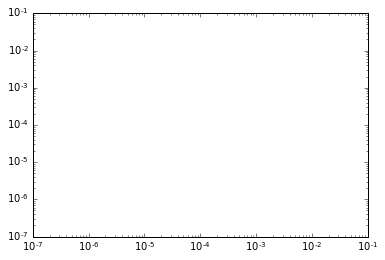

In [65]:
for po in [1,2,3]:
    res = np.array(fsdb.Query('select h,error,time from lfm where poly={0}'.format(po)))
    plt.loglog(res[:,0],res[:,1])

In [35]:
res

array([[0.0011780897107447968, None, 0.6030797958374023],
       [0.0022777122883656763, None, 0.22996187210083008],
       [0.0035144103248475294, None, 0.14413189888000488],
       [0.004409377215082088, None, 0.09093880653381348],
       [0.005617291444058448, None, 0.07403898239135742],
       [0.006008256034118855, None, 0.08088493347167969],
       [0.00739836063084457, None, 0.035353899002075195],
       [0.007988621190524214, None, 0.042391061782836914],
       [0.008739397820817164, None, 0.018684864044189453],
       [0.01033971488082144, None, 0.03286099433898926]], dtype=object)